# Introduction to 2D plots

This notebook demonstrates how plot some latitude by longitude maps of some key surface variables. Most features are available in the preinstalled `geog0111` environment. 

But updated plotting that removes white meridional lines around the Greenwich Meridian, requires the `geog0121` virtual environment. Instructions about how to install this environment (using `conda` and the `environment.yml` file) are provided in the handbook.

### Import packages and define fucntions for calculations

In [1]:
'''Import packages for loading data, analysing, and plotting'''

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline
import cartopy
import cartopy.crs as ccrs
import matplotlib
from netCDF4 import Dataset
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy.ma as ma


import os
import matplotlib.colors as colors

import scipy
from cartopy.util import add_cyclic_point
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


# Change in annual temperature under the SSP585 scenario
Here we use the CVDP output files to look at the change in annual mean surface temperature

In [2]:
#define filenames and their directories
end_period='2071-2100'
start_period='1851-1900'
ssp='ssp585'

directory_a='/data/aod/cvdp_cmip6/geog0121/UKESM1-0-LL_ssps.wrt_%s' %end_period
filename_a='%s/UKESM1_%s_%s.cvdp_data.1850-2100.nc'%(directory_a,ssp,end_period)
directory_b='/data/aod/cvdp_cmip6/geog0121/UKESM1-0-LL_ssps.wrt_%s' %start_period
filename_b='%s/UKESM1_%s_%s.cvdp_data.1850-2100.nc'%(directory_b,ssp,start_period)


# load files
expt_a_file=xr.open_dataset(filename_a,decode_times=False)
expt_b_file=xr.open_dataset(filename_b,decode_times=False)
# load the coordinates
lat=expt_a_file['lat']
lon=expt_a_file['lon']
# load the variables themselves
variable_name='tas_spatialmean_ann'
expt_a=expt_a_file[variable_name]
expt_b=expt_b_file[variable_name]

# create the difference
diff=expt_a-expt_b
diff

<xarray.DataArray 'tas_spatialmean_ann' (lat: 144, lon: 192)>
array([[ 7.007381,  7.001259,  6.999821, ...,  7.013077,  7.011246,  7.007462],
       [ 6.823746,  6.825745,  6.828503, ...,  6.81802 ,  6.820095,  6.821659],
       [ 6.734894,  6.73473 ,  6.73354 , ...,  6.730659,  6.73246 ,  6.735249],
       ...,
       [22.505598, 22.52309 , 22.545275, ..., 22.457348, 22.467459, 22.487543],
       [22.83106 , 22.844997, 22.860886, ..., 22.780483, 22.79882 , 22.815886],
       [23.074162, 23.07485 , 23.076075, ..., 23.072771, 23.073957, 23.073874]],
      dtype=float32)
Coordinates:
  * lat      (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon      (lon) float64 0.9375 2.812 4.688 6.562 ... 353.4 355.3 357.2 359.1

### Using xarray's simplest plotting routine

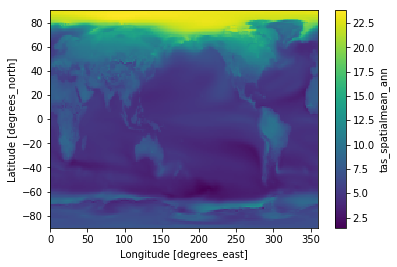

In [3]:
diff.plot()

Whilst this plot clearly show what is going on. It is missing several useful features:
* A sensible colormap
* The coastline (or country borders) to help orientate you
* A logical scale for the colors to use

Whatever you decide to plot, it is always worth selecting a relevant colormap. All of the easily available colormaps can be seen at [Matplotlib's reference pages](https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html). For this instance, I am picking a sequential one that goes from yellow-orange-red (YlOrRd), with the keyword `cmap=` in the plot call.

Here I am going to plot every 2 degrees above preindustrial, using both the `levels` keyword and a call to `np.linspace()`, which subdivides the range from 0-20 (inclusive) into 11 different levels. 

Adding the map is a little trickier. We shall use the Robinson projection, but we need to specify that first along with a load of other map-related options to creates some axes. We then also need to pass these to the plotting routine, as well as telling it us the Plate Carree method to map the locations onto the Robinson projection. 

A final thing to note is that we've switched to using `contourf` instead of the default option (actually `pcolormesh`). This is needed for the maps, and will otherwise throw up errors like 
> 'GeoAxesSubplot' object has no attribute '_hold'


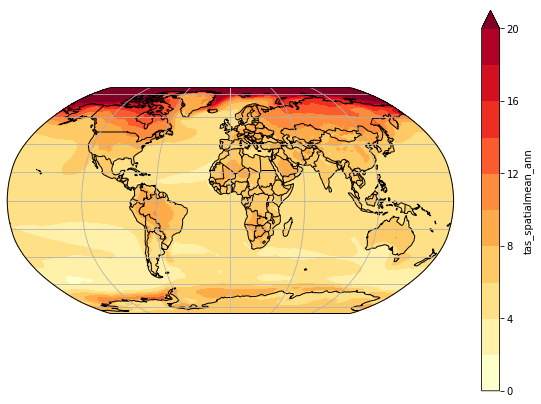

In [4]:
# Define the map projection through an "axes" call
plt.figure(figsize=(10,7)) #make the map itself nice and big
projection = ccrs.Robinson() #specify the Robinson projection
ax = plt.axes(projection=projection) #create the axes
ax.coastlines() # add the coastlines
ax.gridlines() # add some gray gridlines 
ax.add_feature(cartopy.feature.BORDERS) #add the country borders

# Now overplot the map onto these axes. 
fig=diff.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), \
                       cmap='YlOrRd', \
                       levels=np.linspace(0,20,11))

# [note that its given a name of `fig` through the =, so that it can saved later]



# UKESM's El Nino temperature pattern
Here we use the CVDP output files to plot the temperature response to an El Nino. First we will load in the data

In [5]:
#generate filename
directory='/data/aod/cvdp_cmip6/geog0121/UKESM1-0-LL_historical.vsObs' 
filename='%s/UKESM1-0-LL_PresentDay.cvdp_data.1850-2014.nc'%(directory)
# load files
expt_file=xr.open_dataset(filename,decode_times=False)
# load the coordinates
lat=expt_file['lat']
lon=expt_file['lon']
# load the variables themselves
enso_pattern=expt_file.nino34_spacomp_tas_djf1

Then we will specify the colorscale and map

In [6]:
#temperatures
cmap=plt.get_cmap('bwr') #define colormap

#define colormap's range and scale
cmap_limits=[-5,5]
bounds = np.linspace(cmap_limits[0], cmap_limits[1], 21)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

Now we will make a global plot of the El Nino pattern

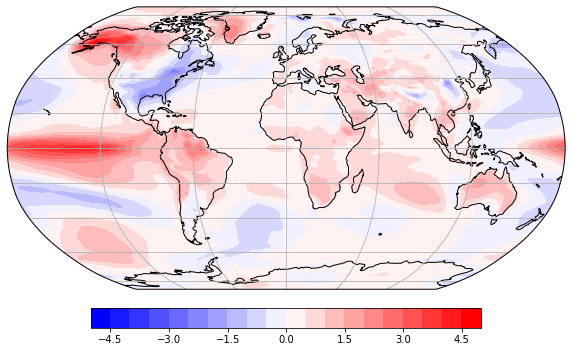

In [7]:
# Choose the map and projection
projection = ccrs.Robinson()
transform=ccrs.PlateCarree()

# Plot the axes
plt.figure(figsize=(10,7))
ax = plt.axes(projection=projection)
ax.coastlines()
ax.gridlines()

# Make the actual figure
fig=ax.contourf(lon,lat,enso_pattern,levels=bounds, transform=transform,cmap=cmap,norm=norm)

# Alter the color bar for the map
cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,shrink=0.7)
plt.colorbar(fig,cax=cax,extend='both',**kw)


And then lets zoom into a smaller region of it

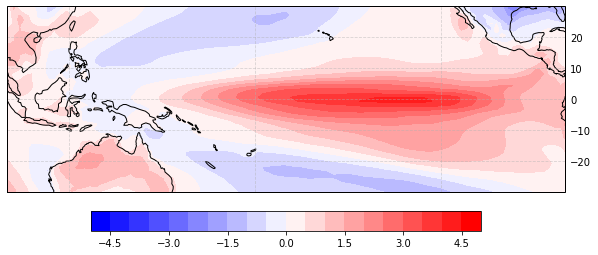

In [9]:
#Regional map
region=[100,280,-30,30] #[lon_min,lon_max,lat_min,lat_max]

# note the specification of the central longitude, so that is spans the dateline
projection = ccrs.PlateCarree(central_longitude=180., globe=None)
transform=ccrs.PlateCarree()

plt.figure(figsize=(10,7))
ax = plt.axes(projection=projection)

ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_left = False
gl.xformatter = LONGITUDE_FORMATTER

fig=ax.contourf(lon,lat,enso_pattern,levels=bounds, transform=transform,cmap=cmap,norm=norm)
ax.set_extent(region, ccrs.PlateCarree())

cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,shrink=0.7)
plt.colorbar(fig,cax=cax,extend='both',**kw)

#plt.savefig(figname)

# Seasonal precipitation anomalies

The CVDP files can be used to create maps of the changes in seasonal precipitation. First we select the variable

In [10]:
#seasonal precipitation anomalies
variable_name='pr_spatialmean_djf'
expt_a=expt_a_file[variable_name]
expt_b=expt_b_file[variable_name]
diff=expt_a-expt_b

Then we define the colormap, and give it a non-linear interval

In [11]:
#precipitations
cmap=plt.get_cmap('BrBG') #define colormap

#define colormap's range and scale
bounds = [-5,-2,-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1,2,5]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

Then we can create a global map with...

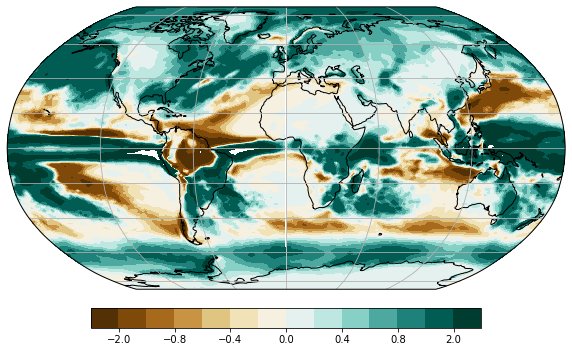

In [12]:
#Global map

projection = ccrs.Robinson()
transform=ccrs.PlateCarree()

plt.figure(figsize=(10,7))
ax = plt.axes(projection=projection)
ax.coastlines()
ax.gridlines()

fig=ax.contourf(lon,lat,diff,levels=bounds, transform=transform,cmap=cmap,norm=norm)
cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,shrink=0.7)
plt.colorbar(fig,cax=cax,extend='both',**kw)

Or a regional map with...

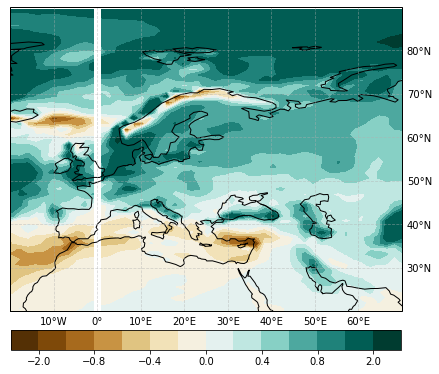

In [13]:
#Regional map
region=[-20,70,20,90] #[lon_min,lon_max,lat_min,lat_max]

projection = ccrs.PlateCarree(central_longitude=0.0, globe=None)
transform=ccrs.PlateCarree()

plt.figure(figsize=(10,7))
ax = plt.axes(projection=projection)

ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
#gl.xlocator = mticker.FixedLocator([-180, -45, 0, 45, 180])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER


fig=ax.contourf(lon,lat,diff,levels=bounds, transform=transform,cmap=cmap,norm=norm)
ax.set_extent(region, ccrs.PlateCarree())

cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,shrink=0.7)
plt.colorbar(fig,cax=cax,extend='both',**kw)



If your regional plot (like this one) happens to cross the Greenwich meridian, then you will end up with a white line going straight up the middle of your regional plot. This can be fixed by adding a "cyclic point" to loop the data around the globe. To understand this, think about how you need to overlap the wrapping paper on a present to cover it completely. 

There is a function in python to do this, but unfortunately it doesn't come in the standard version of python. This function is in the cell below.

You will need to make your own virtual environment called `geog0121` using conda and the yml file provided. If you have not down this, then when you run the code below it will fail with the following error message... 
> TypeError: invalid indexer array

In [ ]:
diff, lon = add_cyclic_point(diff, coord=lon)